<a href="https://colab.research.google.com/github/RodrigoLima82/Tensorflow2.0/blob/master/API_de_Classifica%C3%A7%C3%A3o_de_Imagens_com_TensorFlow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Etapa 1: Instalação das bibliotecas

In [0]:
#!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  12262      0 --:--:-- --:--:-- --:--:-- 12262
OK


In [2]:
#!apt-get install tensorflow-model-server 
#!pip install tensorflow-serving-api
!apt-get update && apt-get install tensorflow-model-server

Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [354 B]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-

In [3]:
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.2MB 51kB/s 
     |████████████████████████████████| 3.2MB 1.2MB/s 
     |████████████████████████████████| 368kB 1.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [4]:
!pip install requests

## Etapa 2: Importação das bibliotecas

In [5]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

'1.13.1'

## Etapa 3: Pré-processamento

### Carregando a base de dados

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Normalização das imagens

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
X_train.shape

(50000, 32, 32, 3)

In [10]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
y_test

## Etapa 4: Definição do modelo

NOTA: Estamos usando o mesmo modelo da seção sobre Redes Neurais Convolucionais

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


### Compilando o modelo

In [0]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

### Treinando o modelo

In [14]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
50000/50000 [==============================] - 11s 226us/sample - loss: 1.0345 - sparse_categorical_accuracy: 0.6360
Epoch 2/10
50000/50000 [==============================] - 11s 222us/sample - loss: 0.8577 - sparse_categorical_accuracy: 0.6992
Epoch 3/10
50000/50000 [==============================] - 11s 222us/sample - loss: 0.7390 - sparse_categorical_accuracy: 0.7419
Epoch 4/10
50000/50000 [==============================] - 11s 222us/sample - loss: 0.6486 - sparse_categorical_accuracy: 0.7729
Epoch 5/10
50000/50000 [==============================] - 11s 222us/sample - loss: 0.5614 - sparse_categorical_accuracy: 0.8038
Epoch 6/10
50000/50000 [==============================] - 11s 222us/sample - loss: 0.4783 - sparse_categorical_accuracy: 0.8352
Epoch 7/10
50000/50000 [==============================] - 11s 224us/sample - loss: 0.4058 - sparse_categorical_accuracy: 0.8586
Epoch 8/10
50000/50000 [==============================] - 11s 222us/sample - loss: 0.3321 - sparse_categ

### Avaliação do modelo

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 175us/sample - loss: 1.0484 - sparse_categorical_accuracy: 0.7388


In [16]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.7387999892234802


## Etapa 5: Salvando o modelo para produção

### Criando o diretório para o modelo

In [0]:
model_dir = "model/"
version = 1

In [18]:
export_path = os.path.join(model_dir, str(version))
export_path

'model/1'

In [0]:
if os.path.isdir(export_path):
  !rm -r {export_path}

### Salvando o modelo para o TensorFlow Serving

In [20]:
model.input

<tf.Tensor 'conv2d_input:0' shape=(?, 32, 32, 3) dtype=float32>

In [21]:
model.outputs

[<tf.Tensor 'dense_1/Softmax:0' shape=(?, 10) dtype=float32>]

In [0]:
o = {t.name: t for t in model.outputs}

In [23]:
o

{'dense_1/Softmax:0': <tf.Tensor 'dense_1/Softmax:0' shape=(?, 10) dtype=float32>}

In [24]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir = export_path,
                           inputs = {"input_image": model.input},
                           outputs = {t.name: t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


## Etapa 6: Configuração do ambiente de produção

### Exportando o MODEL_DIR para as variáveis de ambiente

In [0]:
os.environ["model_dir"] = os.path.abspath(model_dir)

### Executando a API TensorFlow Serving REST

In [26]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${model_dir}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [27]:
!tail server.log

2019-11-27 18:58:31.059978: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-11-27 18:58:31.063429: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-11-27 18:58:31.083906: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-11-27 18:58:31.129399: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 72736 microseconds.
2019-11-27 18:58:31.130824: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2019-11-27 18:58:31.130929: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10 version: 1}
2019-11-27 18:58:31.132302: I tensorflow_serving/

## Etapa 7: Criando a primeira requisição POST

In [0]:
random_image = np.random.randint(0, len(X_test))

In [29]:
random_image

5371

### Criando o objeto JSON

In [0]:
data = json.dumps({"signature_name": "serving_default", "instances": [X_test[random_image].tolist()]})

In [31]:
data

'{"signature_name": "serving_default", "instances": [[[[0.3607843137254902, 0.32941176470588235, 0.21568627450980393], [0.3568627450980392, 0.32941176470588235, 0.21176470588235294], [0.3333333333333333, 0.30196078431372547, 0.18823529411764706], [0.2627450980392157, 0.24313725490196078, 0.12549019607843137], [0.28627450980392155, 0.26666666666666666, 0.14901960784313725], [0.3058823529411765, 0.27450980392156865, 0.17254901960784313], [0.3333333333333333, 0.28627450980392155, 0.20784313725490197], [0.33725490196078434, 0.3058823529411765, 0.2196078431372549], [0.2823529411764706, 0.26666666666666666, 0.16470588235294117], [0.2823529411764706, 0.2627450980392157, 0.15294117647058825], [0.3176470588235294, 0.2901960784313726, 0.17254901960784313], [0.3137254901960784, 0.2823529411764706, 0.16470588235294117], [0.3176470588235294, 0.29411764705882354, 0.1803921568627451], [0.33725490196078434, 0.3176470588235294, 0.19607843137254902], [0.33725490196078434, 0.3176470588235294, 0.192156862

### Enviando a primeira requisição POST para o modelo

In [0]:
headers = {"content-type": "application/json"}

In [0]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data = data, headers = headers)

In [34]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [36]:
predictions

[[2.50432258e-05,
  2.79375627e-06,
  0.135574549,
  0.000133458,
  0.00563704316,
  0.00620655715,
  8.02300474e-06,
  0.852412641,
  6.04964689e-11,
  3.49942972e-08]]

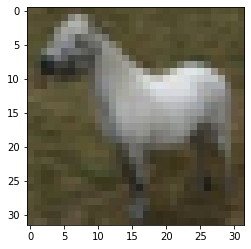

In [37]:
plt.imshow(X_test[random_image])

In [38]:
class_names[np.argmax(predictions[0])]

'horse'

## Etapa 8: Enviando a requisição POST para um modelo específico que está armazendo no servidor

In [0]:
specific_json_response = requests.post(url="http://localhost:8501/v1/models/cifar10/versions/1:predict", data = data, headers = headers)

In [40]:
specific_json_response

<Response [200]>